# Research Skills: Spatiotemporal Data Analyis
## Take-home Assignment
Sharon Ong, Department of Cognitive Science and Artificial Intelligence, 
Tilburg University
Academic Year 2023-2024

Your First Name: Müge

Your Last Name: Bakıryol

Your Student ID: 2032498

For answering these questions, I received guidance from both ChatGPT and practicals provided in this course.

In [37]:
#!pip install statsmodels libpysal spreg
#!pip install geopandas libpysal esda
#!pip install pysal
#!pip install spint
#!pip install numba
#!pip install geopandas
import warnings
import pandas as pd
import numpy as np
from os.path import join
import geopandas as gpd
import statsmodels.api as sm
from esda import Moran_Local
from esda.moran import Moran
from spreg import OLS, ML_Lag
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from esda.moran import Moran_Local
from sklearn.metrics import mean_squared_error
from libpysal.weights import Queen, Rook, KNN, attach_islands
from statsmodels.api import OLS, add_constant
from sklearn.preprocessing import FunctionTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import make_reduction

# Part 2A: Estimating the percentage of votes in the 2023 Netherlands election with spatial autoregression
1. [4 points] 

Load your dataset of election results (XXXXX party.csv). Compute the percentage of votes the party received in each municipality. This is your target variable. Create a histogram plot of your target variable and the features; average income, average house price and population density. Are the target variable and features normally distributed?

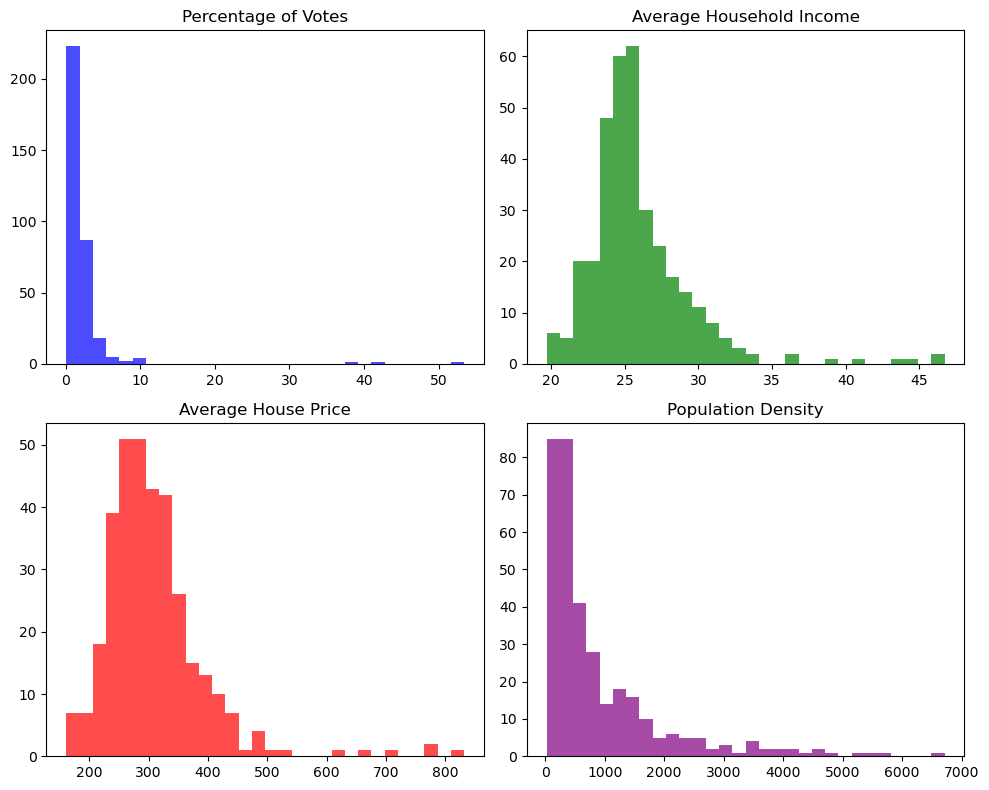

Analysis of Distributions:
1. Percentage of Votes: Skewness = 9.027824983795442 ; Kurtosis = 92.44790421381931
2. Average Household Income: Skewness = 2.458662109195984 ; Kurtosis = 10.164318957702019
3. Average House Price: Skewness = 2.4089920080839233 ; Kurtosis = 10.245552090892012
4. Population Density: Skewness = 2.3828193172007586 ; Kurtosis = 6.475444081527208
By looking at these graphs, it appears that none of the target variables or features are normally distributed.


In [13]:
#
df = pd.read_csv("data/2032498_spatial.csv")

df['Pct Votes'] = (df.iloc[:, 6] / df.iloc[:, 4]) * 100

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].hist(df['Pct Votes'], bins=30, color='blue', alpha=0.7)
axs[0, 0].set_title('Percentage of Votes')

axs[0, 1].hist(df.iloc[:, 7], bins=30, color='green', alpha=0.7)
axs[0, 1].set_title('Average Household Income')

axs[1, 0].hist(df.iloc[:, 6], bins=30, color='red', alpha=0.7)
axs[1, 0].set_title('Average House Price')

axs[1, 1].hist(df.iloc[:, 8], bins=30, color='purple', alpha=0.7)
axs[1, 1].set_title('Population Density')

plt.tight_layout()
plt.show()

print("Analysis of Distributions:")
print("1. Percentage of Votes: Skewness =", df['Pct Votes'].skew(), "; Kurtosis =", df['Pct Votes'].kurt())
print("2. Average Household Income: Skewness =", df.iloc[:, 7].skew(), "; Kurtosis =", df.iloc[:, 7].kurt())
print("3. Average House Price: Skewness =", df.iloc[:, 6].skew(), "; Kurtosis =", df.iloc[:, 6].kurt())
print("4. Population Density: Skewness =", df.iloc[:, 8].skew(), "; Kurtosis =", df.iloc[:, 8].kurt())

print('By looking at these graphs, it appears that none of the target variables or features are normally distributed.')
#

2. [6 points] 
Load the shapefile of the townships of the Netherlands and display the first five rows. Remove all the polygons (and multipolygons) representing water. Note, you do not have to display the Choropleth Map of your results, but you can if you want to. Create a new column called Pct Votes in the geodataframe and copy over the contents in column containing the percentage of votes in the dataframe from Question 1. Display a Choropleth Map of the townships, with colors assigned by Pct Votes (columns=Pct Votes). Use a quantiles scheme with 5 quantiles.

In [39]:
#
shapefile_path = "data/wijbuurtkart_2023_v1/gemeenten_2023_v1.shp"
gdf = gpd.read_file(join('data', 'wijkbuurtkaart_2023_v1', 'gemeenten_2023_v1.shp'))

gdf = gdf[gdf['H2O'] != 'JA']


gdf = gdf.merge(df[['GM_NAAM', 'Pct Votes']], on='GM_NAAM', how='left')

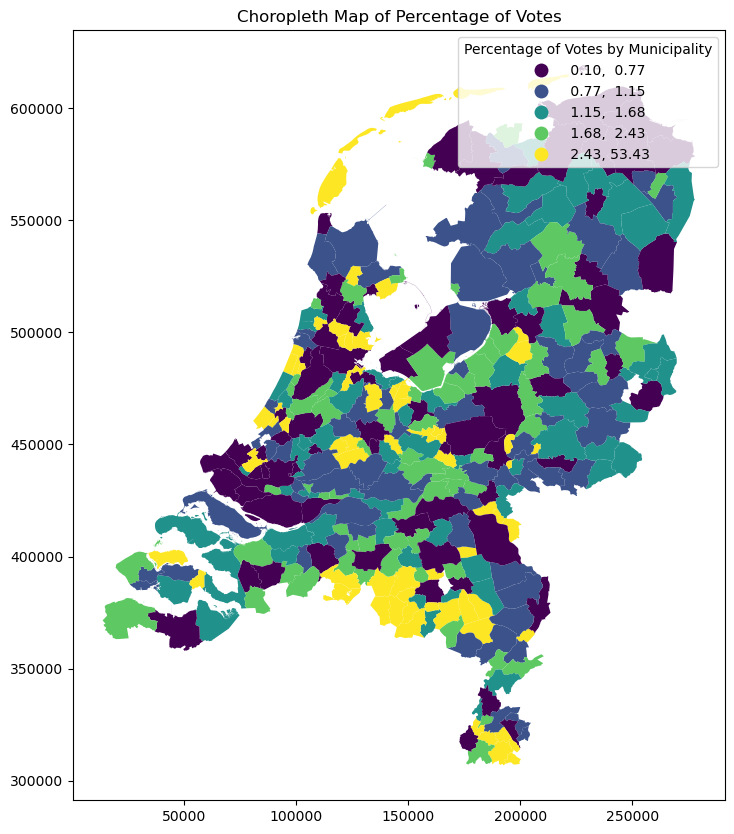

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='Pct Votes', ax=ax, legend=True,
         legend_kwds={'title': "Percentage of Votes by Municipality"},
         scheme='quantiles', cmap='viridis', k=5)
plt.title('Choropleth Map of Percentage of Votes')
plt.show()
#

3. [10 points] 

Using contiguity based weighting schemes (rook and queen) and KNN based weighingt schemes, compute and compare the global autocorrelation (Global Moran’s I) of Pct Votes and the log transformation of the Pct Votes. Try at least 2 different K number of neighbours. Which feature (Pct Votes or its log transformation) has a higher autocorrelation?

In [42]:
#
def fill_islands(weights, gdf):
    islands = weights.islands.copy()
    if islands:
        for island in islands:
            nearest = None
            min_dist = float('inf')
            island_point = gdf.loc[island].geometry.centroid
            for idx, row in gdf.iterrows():
                if idx in islands:
                    continue
                dist = island_point.distance(row.geometry.centroid)
                if dist < min_dist:
                    nearest = idx
                    min_dist = dist
            if nearest is not None:
                if island not in weights.neighbors:
                    weights.neighbors[island] = []
                    weights.weights[island] = []
                weights.neighbors[island].append(nearest)
                weights.weights[island].append(1)
                if nearest not in weights.neighbors:
                    weights.neighbors[nearest] = []
                    weights.weights[nearest] = []
                weights.neighbors[nearest].append(island)
                weights.weights[nearest].append(1)
    return weights

# Ensure no negative or zero values before applying log transformation
gdf['Pct Votes'] = gdf['Pct Votes'].replace(0, np.nan)
gdf = gdf.dropna(subset=['Pct Votes'])
gdf['Log Pct Votes'] = np.log1p(gdf['Pct Votes'])

weights_rook = fill_islands(Rook.from_dataframe(gdf), gdf)
weights_queen = fill_islands(Queen.from_dataframe(gdf), gdf)
weights_knn_4 = fill_islands(KNN.from_dataframe(gdf, k=4), gdf)
weights_knn_8 = fill_islands(KNN.from_dataframe(gdf, k=8), gdf)

def calculate_morans_i(df, column, w):
    w.transform = 'R'
    moran = Moran(df[column], w)
    return moran.I, moran.p_sim

results = []
weights_list = [weights_rook, weights_queen, weights_knn_4, weights_knn_8]
names = ['Rook', 'Queen', 'KNN-4', 'KNN-8']

for name, w in zip(names, weights_list):
    mi_pct, p_pct = calculate_morans_i(gdf, 'Pct Votes', w)
    mi_log_pct, p_log_pct = calculate_morans_i(gdf, 'Log Pct Votes', w)
    results.append((name, 'Pct Votes', mi_pct, p_pct))
    results.append((name, 'Log Pct Votes', mi_log_pct, p_log_pct))

for result in results:
    print(f"Weighting scheme: {result[0]}, Feature: {result[1]}, Moran's I: {result[2]:.4f}, p-value: {result[3]:.4f}")

df_results = pd.DataFrame(results, columns=['Weighting Scheme', 'Feature', 'Moran\'s I', 'p-value'])
print(df_results)
#

C:\Users\friez\anaconda3\lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\friez\AppData\Local\Temp\ipykernel_18316\152280165.py:34: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights_rook = fill_islands(Rook.from_dataframe(gdf), gdf)
C:\Users\friez\anaconda3\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 2 islands with ids: 6, 12.
  warnings.warn(message)
C:\Users\friez\AppData\Local\Temp\ipykernel_18316\152280165.py:35: FutureWarning: `use

Weighting scheme: Rook, Feature: Pct Votes, Moran's I: 0.0806, p-value: 0.0370
Weighting scheme: Rook, Feature: Log Pct Votes, Moran's I: 0.1494, p-value: 0.0010
Weighting scheme: Queen, Feature: Pct Votes, Moran's I: 0.0784, p-value: 0.0310
Weighting scheme: Queen, Feature: Log Pct Votes, Moran's I: 0.1441, p-value: 0.0010
Weighting scheme: KNN-4, Feature: Pct Votes, Moran's I: 0.0288, p-value: 0.0800
Weighting scheme: KNN-4, Feature: Log Pct Votes, Moran's I: 0.0874, p-value: 0.0110
Weighting scheme: KNN-8, Feature: Pct Votes, Moran's I: 0.0289, p-value: 0.0660
Weighting scheme: KNN-8, Feature: Log Pct Votes, Moran's I: 0.0542, p-value: 0.0150
  Weighting Scheme        Feature  Moran's I  p-value
0             Rook      Pct Votes   0.080614    0.037
1             Rook  Log Pct Votes   0.149370    0.001
2            Queen      Pct Votes   0.078408    0.031
3            Queen  Log Pct Votes   0.144082    0.001
4            KNN-4      Pct Votes   0.028830    0.080
5            KNN-4  Lo

4. [10 points] 
Compute the local autocorrelation for the same two features. Choose the weighting scheme and parameters for which gave you the highest correlation in 3.3. Identify the ’hotspots’ and ’coldspots’ by display the hotspots as these townships with different colors in a scatter plot.

C:\Users\friez\AppData\Local\Temp\ipykernel_18316\4242558612.py:9: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights_rook = Rook.from_dataframe(gdf_clean, silence_warnings=True)
C:\Users\friez\anaconda3\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 78 disconnected components.
  warnings.warn(message)


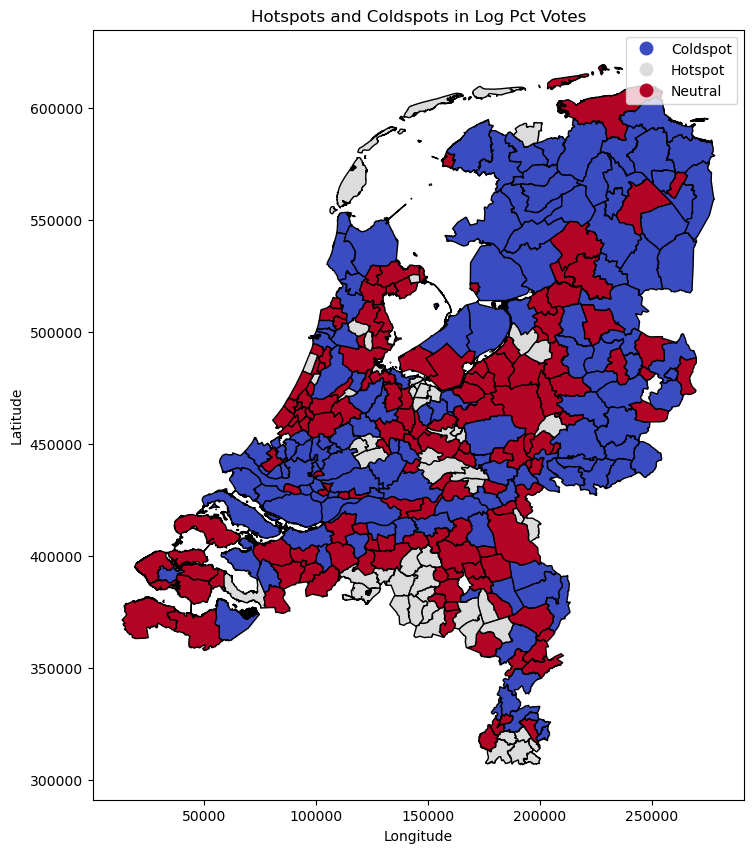

In [44]:
#
gdf_clean = gdf.copy()
gdf_clean['Pct Votes'] = gdf_clean['Pct Votes'].replace(0, np.nan)
gdf_clean = gdf_clean.dropna(subset=['Pct Votes'])
gdf_clean['Log Pct Votes'] = np.log1p(gdf_clean['Pct Votes'])

gdf_clean.reset_index(drop=True, inplace=True)

weights_rook = Rook.from_dataframe(gdf_clean, silence_warnings=True)

def attach_islands(weights, gdf):
    islands = weights.islands.copy()
    if islands:
        for island in islands:
            nearest = None
            min_dist = float('inf')
            island_point = gdf.loc[island].geometry.centroid
            for idx, row in gdf.iterrows():
                if idx in islands:
                    continue
                dist = island_point.distance(row.geometry.centroid)
                if dist < min_dist:
                    nearest = idx
                    min_dist = dist
            if nearest is not None:
                if island not in weights.neighbors:
                    weights.neighbors[island] = []
                    weights.weights[island] = []
                weights.neighbors[island].append(nearest)
                weights.weights[island].append(1)
                if nearest not in weights.neighbors:
                    weights.neighbors[nearest] = []
                    weights.weights[nearest] = []
                weights.neighbors[nearest].append(island)
                weights.weights[nearest].append(1)
    return weights

if weights_rook.islands:
    weights_knn1 = KNN.from_dataframe(gdf_clean, k=1)
    weights_rook = attach_islands(weights_rook, gdf_clean)

log_pct_votes_array = gdf_clean['Log Pct Votes'].to_numpy()

try:
    local_moran_log_pct_votes = Moran_Local(log_pct_votes_array, weights_rook)

    gdf_clean['moran_local_I'] = local_moran_log_pct_votes.Is
    gdf_clean['p_value'] = local_moran_log_pct_votes.p_sim
    gdf_clean['quadrant'] = local_moran_log_pct_votes.q

    gdf_clean['hotspot_pvv'] = 'Neutral'
    gdf_clean.loc[gdf_clean['quadrant'] == 1, 'hotspot_pvv'] = 'Hotspot'
    gdf_clean.loc[gdf_clean['quadrant'] == 3, 'hotspot_pvv'] = 'Coldspot'

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    gdf_clean.plot(column='hotspot_pvv', cmap='coolwarm', legend=True, ax=ax, edgecolor='k')
    plt.title('Hotspots and Coldspots in Log Pct Votes')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

except Exception as e:
    print(f"An error occurred: {str(e)}")


5. [2 points] Perform a log transformation of your target variable, population density, average income and average house price features

In [46]:
#
df['Log Pct Votes'] = np.log1p(df['Pct Votes'])
df['Log Population Density'] = np.log1p(df['Population_Density'])
df['Log Average Income'] = np.log1p(df['Average_Income'])
df['Log Average House Price'] = np.log1p(df['Average_House_Price'])

print(df.head()) 
#

       GM_NAAM GM_CODE OuderRegioCode GrootOuderRegioCode  TotalVotes    D66  \
0    Groningen   G0014             K1                 P20      146649  13262   
1       Almere   G0034             K5                 P24      104685   5687   
2  Stadskanaal   G0037             K1                 P20       19335    435   
3      Veendam   G0047             K1                 P20       16441    612   
4     Zeewolde   G0050             K5                 P24       14376    740   

   Average_House_Price  Average_Income  Population_Density  \
0                258.9            23.3                1266   
1                294.3            24.7                1686   
2                185.5            20.5                 271   
3                187.5            21.6                 362   
4                275.7            25.7                  94   

   Population_Increase  Pct Votes  Log Pct Votes  Log Population Density  \
0                   57   0.176544       0.162581                7.1444

6. [8 points] 
Your goal is to estimate of Pct Votes (log values) per municipality based on the explanatory variables (the average house price and population density) and the spatially lagged Pct Votes (endogenous regressor). Please use the log form of the variables from Question 5 for this question. Please use the “spreg” package for this task and the weighting scheme you selected in Question 4. Chose two weighing
scheme to compare
(a) Fit a linear regression model, where your target variable is the Pct Votes (in log form) and your features (exploratory variables) are population density, average income and average house price features (in log form).
(b) Using the GM Lag, run a spatial autoregression model with the features in (a).
Compare the mean square error for these 4 estimators. Which regressor model resulted in the lowest
mean square error

In [48]:
#
warnings.filterwarnings("ignore")
if 'Log Population Density' not in gdf.columns:
    gdf['Log Population Density'] = np.log1p(gdf['BEV_DICHTH'])

gdf.dropna(subset=['Log Pct Votes', 'Log Population Density'], inplace=True)
gdf.replace([np.inf, -np.inf], np.nan, inplace=True)
gdf.dropna(inplace=True)

if gdf.empty:
    print("No data available after cleaning.")
else:
    X = gdf[['Log Population Density']]
    y = gdf['Log Pct Votes']

    X_const = add_constant(X)

    try:
        model_ols = OLS(y, X_const).fit()
        predictions_ols = model_ols.predict(X_const)
        mse_ols = mean_squared_error(y, predictions_ols)
        print("MSE - OLS:", mse_ols)

        w_queen = Queen.from_dataframe(gdf)
        w_queen.transform = 'r'

        model_lag_queen = ML_Lag(y.values.reshape(-1, 1), X.values, w=w_queen, name_y='Log Pct Votes', name_x=['Density'])
        predictions_lag_queen = model_lag_queen.predy
        mse_lag_queen = mean_squared_error(y, predictions_lag_queen.flatten())
        print("MSE - Spatial Lag Model (Queen):", mse_lag_queen)

        if mse_ols < mse_lag_queen:
            print("Model with the lowest MSE: OLS")
        else:
            print("Model with the lowest MSE: Spatial Lag (Queen)")

    except Exception as e:
        print("Error in fitting the model:", e)
#

MSE - OLS: 0.22317779596128623
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 12, ' is an island (no neighbors)')
MSE - Spatial Lag Model (Queen): 0.21707200754135014
Model with the lowest MSE: Spatial Lag (Queen)
